In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

# tf and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import tensorflow_datasets as tfds

# BERT
from transformers import AutoTokenizer, TFAutoModel
from transformers import TFAutoModelForSequenceClassification
from transformers import BertTokenizer, TFBertForSequenceClassification

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

# others
import re
import tqdm
import warnings
warnings.filterwarnings("ignore")

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


random.seed(2)
%matplotlib inline

# FILL IN CODE HERE #
DATA_PATH = './' # replace with your path

2022-07-21 00:54:17.315232: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-21 00:54:17.315327: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max


``Functions``

In [2]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

In [3]:
def confusion_matrix_plot(conf_matrix):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

---
## Read data

In [4]:
df_init = pd.read_csv('./drugs_raw.csv')
print('Number of reviews:', df_init.shape[0])
print('Reviews collected between:', df_init.date.min(), 'and ', df_init.date.max())
print('Unique rating values:', np.sort(df_init.rating.unique()))
df_init.head()

Number of reviews: 215063
Reviews collected between: April 1, 2008 and  September 9, 2017
Unique rating values: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


---
## Data preprocessing

When building a neural network, it is import to get the data into the proper form. Let's do a couple of text preprocessing steps.

``Step 1: Remove unwanted review characters``

In [5]:
# remove HTML markup, punctuation, and other non-letter characters
df_init['review'] = df_init['review'].apply(preprocessor)

``Step 2: Remove outlier reviews``

I want to remove any reviews with no text or extremely long text. Let's see if we find any such reviews.

In [6]:
# find zero-length reviews
zero_len_reviews = df_init[df_init['review'].str.len().eq(1)]
print("Zero-length reviews: {}".format(zero_len_reviews.shape[0]))
display(zero_len_reviews)

Zero-length reviews: 2


,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
123174,123174,Ifosfamide,Testicular Cance,,10.0,"January 8, 2017",0
128652,128652,Ifex,Testicular Cance,,10.0,"January 8, 2017",0


In [7]:
# find extremely long text reviews
print('Distribution of review length:')
display(df_init.review.str.len().describe())

# print number of reviews with more than 800 tokens
print('\nReviews with more than 800 tokens:', df_init[df_init.review.str.len().gt(800)].shape[0])

Distribution of review length:


count    215063.000000
mean        444.877552
std         233.744124
min           1.000000
25%         254.000000
50%         443.000000
75%         670.000000
max       10416.000000
Name: review, dtype: float64


Reviews with more than 800 tokens: 690


It seems that I have two reviews with zero length and 374 reviews with more than 1000 tokens. I am going to remove them from our data.

In [8]:
# remove zero length and extremely long reviews
df_init = df_init[df_init['review'].str.len().gt(1) & df_init['review'].str.len().le(800)]
print('Number of reviews:', df_init.shape[0])

Number of reviews: 214371


Finally, let's look at the distribution of our reviews length after preprocessing

Text(0.5, 0, 'Number of tokens per review')

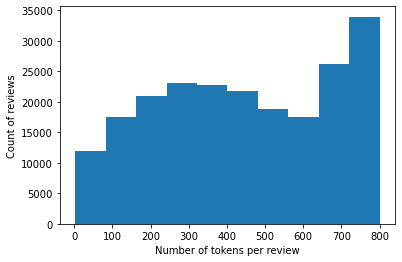

In [9]:
plt.hist(df_init.review.str.len());
plt.ylabel('Count of reviews')
plt.xlabel('Number of tokens per review')

``Step 2: Create binary sentiment column``

We will define our sentiment column as follows:

   - positive (1) if rating score is between 8-10
   - negative (0) if rating score is between 1-3
    
We dill drop any reviews that are netural, i.e., rating is between 4-7.

In [10]:
# create sentiment column
df_init['sentiment'] = np.where(df_init.rating.isin((1, 2, 3)), 'negative',
                          np.where(df_init.rating.isin((8,9,10)), 'positive', 'neutral'))

# drop review if sentiment is netural
df = df_init[~df_init.sentiment.eq('neutral')]

# rename sentiment to positive = 1, negative = 0
df['sentiment'] = np.where(df.sentiment.eq('positive'), 1, 0)

Let's do a quick inspection of our rating and sentiment columns

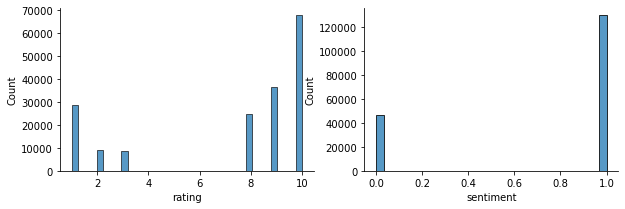

In [11]:
# rating and sentiment histogram after preprocessing
cols = ['rating', 'sentiment']
nrows, ncols = 1, 2

f, axs = plt.subplots(1, 2, figsize=(10,3))
for idx, ax in enumerate(axs):
    sns.histplot(
    data=df,
    stat="count",
    x = cols[idx],
    ax=ax
    )

    # add labels and ticks
    ax.set(xlabel=cols[idx])
    #plt.xticks(np.arange(1,11,1))
    sns.despine()

Our dataset is very imbalanced. We will correct for class imbalance by taking only 46,000 random examples from each class.

In [12]:
# randomly draw 46000 examples from each class
temp_positive = df[df.sentiment.eq(1)].sample(
    n=46000,
    replace=False
)

temp_negative = df[df.sentiment.eq(0)].sample(
    n=46000,
    replace=False
)

df_balanced = pd.concat(
    [temp_positive, temp_negative],
    axis=0)

# shuffle df_balanced
df_balanced.sample(frac=1) # frac=1 retains all the data
df_balanced.reset_index(drop=True, inplace=True) # reset index

print('After preprocessing, our data contains', df_balanced.shape[0], 'reviews.')

After preprocessing, our data contains 92000 reviews.


``Step 3: Split data into training, val, test``

We will do a [60, 20, 20] split between training, validation and test sets

In [13]:
# first, keep only review and sentiment from df_balanced
df_balanced = df_balanced[['review', 'sentiment']]
df_balanced.head(5)

,review,sentiment
0,prior to starting med school i was having num...,1
1,i 039 ve smoked for four years started at age...,1
2,i have been using yaz birth control since jul...,1
3,this medicine was given to me after dental wo...,1
4,there are no two ways about it vivitrol saved...,1


In [14]:
# split = [60, 20, 20]
train_valid_reviews, test_reviews, train_valid_labels, test_labels =train_test_split(
    df_balanced.review,
    df_balanced.sentiment,
    test_size=0.20,
    random_state=1,
    shuffle=True
)

train_reviews, valid_reviews, train_labels, valid_labels = train_test_split(
    train_valid_reviews,
    train_valid_labels,
    test_size=0.20,
    random_state=1,
    shuffle=True
)

In [15]:
print('Size train reviews:', len(train_reviews))
print('Size dev reviews', len(valid_reviews))
print('Size test reviews', len(test_reviews))

Size train reviews: 58880
Size dev reviews 14720
Size test reviews 18400


``Step 4: Transfer learning on BERT (trainable BERT layers)``

Supporting functions

In [50]:
def batch_encode(X, tokenizer, max_seq_len):
    return tokenizer.batch_encode_plus(
    X,
    max_length=max_seq_len,
    add_special_tokens=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_tensors='tf'
)

In [51]:
def create_model(max_sequence_len, model_name, num_labels):
    # BERT layers are trainable by default
    bert_model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    input_ids = keras.layers.Input(shape=(max_sequence_len,), dtype=tf.int32, name='input_ids')
    attention_mask = keras.layers.Input((max_sequence_len,), dtype=tf.int32, name='attention_mask')
    
    # Use input_ids and attention_mask as input to BERT
    output = bert_model([input_ids, attention_mask])[0]

    # Append our classification layer to BERT
    output = keras.layers.Dense(num_labels, activation='sigmoid')(output)

    model = keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)
    
    return model

In [52]:
max_seq_len = 128
model_name = "cambridgeltl/SapBERT-from-PubMedBERT-fulltext" 

In [53]:
# Load PubMedBERT tokenizer

tokenizer = BertTokenizer.from_pretrained(model_name)

In [54]:
# Prepare our input values (tokenizing, adding special tokens, padding, and attention mask)

train_x = batch_encode(train_reviews, tokenizer, max_seq_len)
val_x = batch_encode(valid_reviews, tokenizer, max_seq_len)
test_x = batch_encode(test_reviews, tokenizer, max_seq_len)

train_y = train_labels
val_y = valid_labels
test_y = test_labels

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [21]:
# Create and compile model

model = create_model(max_seq_len, model_name, 1)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-5), 
              loss='binary_crossentropy', 
              metrics=['binary_accuracy'])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at cambridgeltl/SapBERT-from-PubMedBERT-fulltext and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
checkpoint = keras.callbacks.ModelCheckpoint("./transfer_models/{epoch:02d}-{val_binary_accuracy:.3f}", 
                                             monitor="val_binary_accuracy", 
                                             mode="max",
                                             save_best_only=True,
                                             weights_only=False,
                                             verbose=1)

hist = model.fit(
    x=train_x.values(),
    y=train_y,
    validation_data=(val_x.values(), val_y),
    epochs=25,
    batch_size=32,
    callbacks=[checkpoint]
)

Epoch 1/25


2022-07-21 00:57:30.001540: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1840/1840 [==============================] - ETA: 0s - loss: 0.2660 - binary_accuracy: 0.8901
Epoch 1: val_binary_accuracy improved from -inf to 0.93132, saving model to ./transfer_models/01-0.931


2022-07-21 01:17:46.546442: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./transfer_models/01-0.931/assets


INFO:tensorflow:Assets written to: ./transfer_models/01-0.931/assets


1840/1840 [==============================] - 1248s 674ms/step - loss: 0.2660 - binary_accuracy: 0.8901 - val_loss: 0.1867 - val_binary_accuracy: 0.9313
Epoch 2/25
1840/1840 [==============================] - ETA: 0s - loss: 0.1451 - binary_accuracy: 0.9469
Epoch 2: val_binary_accuracy improved from 0.93132 to 0.93302, saving model to ./transfer_models/02-0.933


INFO:tensorflow:Assets written to: ./transfer_models/02-0.933/assets


INFO:tensorflow:Assets written to: ./transfer_models/02-0.933/assets


1840/1840 [==============================] - 1173s 637ms/step - loss: 0.1451 - binary_accuracy: 0.9469 - val_loss: 0.1766 - val_binary_accuracy: 0.9330
Epoch 3/25
1840/1840 [==============================] - ETA: 0s - loss: 0.0892 - binary_accuracy: 0.9690
Epoch 3: val_binary_accuracy improved from 0.93302 to 0.94355, saving model to ./transfer_models/03-0.944


INFO:tensorflow:Assets written to: ./transfer_models/03-0.944/assets


INFO:tensorflow:Assets written to: ./transfer_models/03-0.944/assets


1840/1840 [==============================] - 1146s 623ms/step - loss: 0.0892 - binary_accuracy: 0.9690 - val_loss: 0.1806 - val_binary_accuracy: 0.9435
Epoch 4/25
1840/1840 [==============================] - ETA: 0s - loss: 0.0593 - binary_accuracy: 0.9805
Epoch 4: val_binary_accuracy improved from 0.94355 to 0.94375, saving model to ./transfer_models/04-0.944


INFO:tensorflow:Assets written to: ./transfer_models/04-0.944/assets


INFO:tensorflow:Assets written to: ./transfer_models/04-0.944/assets


1840/1840 [==============================] - 1139s 619ms/step - loss: 0.0593 - binary_accuracy: 0.9805 - val_loss: 0.1809 - val_binary_accuracy: 0.9438
Epoch 5/25
1840/1840 [==============================] - ETA: 0s - loss: 0.0463 - binary_accuracy: 0.9850
Epoch 5: val_binary_accuracy improved from 0.94375 to 0.94667, saving model to ./transfer_models/05-0.947


INFO:tensorflow:Assets written to: ./transfer_models/05-0.947/assets


INFO:tensorflow:Assets written to: ./transfer_models/05-0.947/assets


1840/1840 [==============================] - 1135s 617ms/step - loss: 0.0463 - binary_accuracy: 0.9850 - val_loss: 0.1840 - val_binary_accuracy: 0.9467
Epoch 6/25
1840/1840 [==============================] - ETA: 0s - loss: 0.0377 - binary_accuracy: 0.9878
Epoch 6: val_binary_accuracy did not improve from 0.94667
1840/1840 [==============================] - 1094s 595ms/step - loss: 0.0377 - binary_accuracy: 0.9878 - val_loss: 0.2108 - val_binary_accuracy: 0.9442
Epoch 7/25
1840/1840 [==============================] - ETA: 0s - loss: 0.0312 - binary_accuracy: 0.9896
Epoch 7: val_binary_accuracy did not improve from 0.94667
1840/1840 [==============================] - 1104s 600ms/step - loss: 0.0312 - binary_accuracy: 0.9896 - val_loss: 0.2810 - val_binary_accuracy: 0.9448
Epoch 8/25
1840/1840 [==============================] - ETA: 0s - loss: 0.0286 - binary_accuracy: 0.9908
Epoch 8: val_binary_accuracy did not improve from 0.94667
1840/1840 [==============================] - 1100s 598m

INFO:tensorflow:Assets written to: ./transfer_models/13-0.949/assets


INFO:tensorflow:Assets written to: ./transfer_models/13-0.949/assets


1840/1840 [==============================] - 1128s 613ms/step - loss: 0.0187 - binary_accuracy: 0.9940 - val_loss: 0.2445 - val_binary_accuracy: 0.9488
Epoch 14/25
1840/1840 [==============================] - ETA: 0s - loss: 0.0184 - binary_accuracy: 0.9944
Epoch 14: val_binary_accuracy did not improve from 0.94885
1840/1840 [==============================] - 1082s 588ms/step - loss: 0.0184 - binary_accuracy: 0.9944 - val_loss: 0.2414 - val_binary_accuracy: 0.9484
Epoch 15/25
1840/1840 [==============================] - ETA: 0s - loss: 0.0175 - binary_accuracy: 0.9943
Epoch 15: val_binary_accuracy did not improve from 0.94885
1840/1840 [==============================] - 1084s 589ms/step - loss: 0.0175 - binary_accuracy: 0.9943 - val_loss: 0.2677 - val_binary_accuracy: 0.9480
Epoch 16/25
1840/1840 [==============================] - ETA: 0s - loss: 0.0159 - binary_accuracy: 0.9948
Epoch 16: val_binary_accuracy improved from 0.94885 to 0.94980, saving model to ./transfer_models/16-0.950


INFO:tensorflow:Assets written to: ./transfer_models/16-0.950/assets


INFO:tensorflow:Assets written to: ./transfer_models/16-0.950/assets


1840/1840 [==============================] - 1120s 609ms/step - loss: 0.0159 - binary_accuracy: 0.9948 - val_loss: 0.2463 - val_binary_accuracy: 0.9498
Epoch 17/25
1840/1840 [==============================] - ETA: 0s - loss: 0.0154 - binary_accuracy: 0.9950
Epoch 17: val_binary_accuracy did not improve from 0.94980
1840/1840 [==============================] - 1082s 588ms/step - loss: 0.0154 - binary_accuracy: 0.9950 - val_loss: 0.2755 - val_binary_accuracy: 0.9471
Epoch 18/25
1840/1840 [==============================] - ETA: 0s - loss: 0.0152 - binary_accuracy: 0.9955
Epoch 18: val_binary_accuracy did not improve from 0.94980
1840/1840 [==============================] - 1084s 589ms/step - loss: 0.0152 - binary_accuracy: 0.9955 - val_loss: 0.2889 - val_binary_accuracy: 0.9436
Epoch 19/25
1840/1840 [==============================] - ETA: 0s - loss: 0.0143 - binary_accuracy: 0.9954
Epoch 19: val_binary_accuracy did not improve from 0.94980
1840/1840 [==============================] - 1083

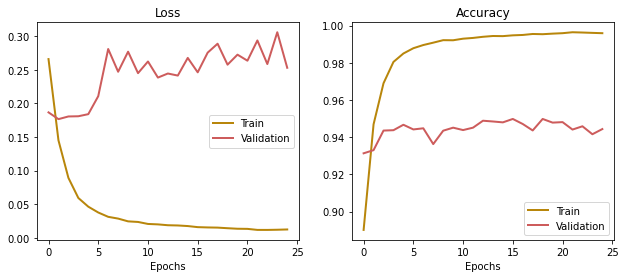

In [23]:
# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.5,0.7)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_binary_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.7,0.8)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');

In [24]:
print('After training this model, evaluation on the validation data shows an accuracy of:',
      np.round(history['val_binary_accuracy'][-1]*100,2), '%'
)

After training this model, evaluation on the validation data shows an accuracy of: 94.44 %


In [26]:
print('Greatest validation accuracy:',
      np.round(max(history['val_binary_accuracy'])*100,2), '%'
)

Greatest validation accuracy: 94.98 %


How good is this score? Let's compare it with a dummy classifier.

<span style="color:chocolate">Question: </span> what is a dummy classifier?

In [29]:
clf = DummyClassifier() # uses Sklearn 

scores = cross_val_score(clf, train_reviews, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.501 (+/- 0.00)


---
## Evaluation

<span style="color:chocolate">predictions on test data</span> 

In [55]:
# run the trained model on the test data (the model outputs probabilities)
y_test_pred_p = model.predict(x=test_x.values()).flatten()

# apply the threshold function to create a 0, 1 outcome
y_test_pred = np.where(y_test_pred_p>=0.5, 1, 0)
y_test_pred[:10] # first 10 only

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 0])

<span style="color:chocolate">confussion matrix</span> 

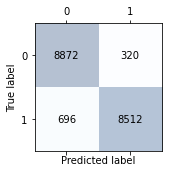

In [56]:
conf_matrix = tf.math.confusion_matrix(
    test_y,
    y_test_pred,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

confusion_matrix_plot(conf_matrix.numpy())

<span style="color:chocolate">precision score</span> 

In [57]:
# note that TensorFlow assumes that the positive class is cultivar 1
p = tf.keras.metrics.Precision(
    thresholds=None, top_k=None, class_id=None, name=None, dtype=None
)
p.update_state(test_y, y_test_pred)  #18/(18+3)
print("Precision score: %3f" %p.result().numpy())

Precision score: 0.963768


<span style="color:chocolate">recall score</span> 

In [58]:
# note that TensorFlow assumes that the positive class is cultivar 1
r = tf.keras.metrics.Recall(
    thresholds=None, top_k=None, class_id=None, name=None, dtype=None
)
r.update_state(test_y, y_test_pred) #18/(18+1)
print("Recall score: %.3f" %r.result().numpy())

Recall score: 0.924


<span style="color:chocolate">F1 score</span> 

In [59]:
print("F1 score:",
    2*((p.result().numpy()*r.result().numpy())/(p.result().numpy()+r.result().numpy())))

F1 score: 0.9436807632446289


<span style="color:chocolate">ROC AUC</span> 

ROC AUC: 0.983


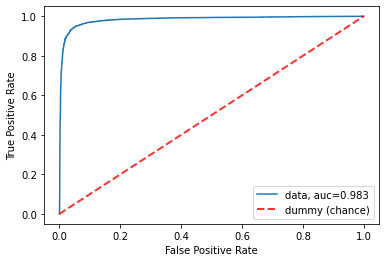

In [60]:
from sklearn import datasets, metrics, model_selection, svm
fpr, tpr, _ = metrics.roc_curve(test_y,  y_test_pred_p)
auc = metrics.roc_auc_score(test_y, y_test_pred_p)
plt.plot(fpr,tpr,label="data, auc="+str(np.round(auc,3)))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


# add dummy classifier
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='dummy (chance)', alpha=.8)

plt.legend(loc=4)
print('ROC AUC:', np.round(auc,3))